> > # Titanic Corvus Solution
## Top 15% Using Simple Classifiers
Hi. Welcome to my very first Kaggle Notebook, solving the classical Titanic problem. It's an interesting question, since it's possible to explore the basic framework necessary to solve a Machine Learning problem, using a small dataset with a easy perspective to test different models and techniques.

# 1. Libraries
It's a good practice to include all the used libraries on the top of the code structure:

In [4]:
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import inspect
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import seaborn as sns
import statistics as sta
import graphviz

from xgboost import XGBClassifier
from plotnine import *
from collections import Counter

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import learning_curve
from IPython.display import clear_output, display

Let's also change the font color and size in our matplotlib graphics...

In [5]:
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(wspace = 15, hspace = 15)

<Figure size 432x288 with 0 Axes>

# 2. Feature Engineering
Time to start! The first step in our solution is to analyse every feature that we have, starting by an overview of the dataset.

# 2.1. Dataset Overview

First, let's take a fast looking at the table we have.

In [6]:
original_training_df =  pd.read_csv('./train.csv')
original_training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Then, we can check the general attributes of our data and the non null elements

In [7]:
original_training_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
original_training_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
original_training_df.isnull().sum().divide(len(original_training_df.index)).multiply(100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [10]:
original_training_df['Name'][1:10]

1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

# 2.2. Extract Title from Name

So, we have a first insight. Time to ask ourselves: would it be possible to extract more informations of this table? And ths answer is: yes, of course! We can, for instance, extract the title of every person from the "Name" column

In [11]:
def get_title(dataframe_in):
    dataframe_in['Title'] = dataframe_in['Name'].apply(lambda X: re.search('[A-Z]{1}[a-z]+\.', X).group(0))
    return dataframe_in
    
dataframe_transformations_test = original_training_df.copy()
dataframe_transformations_test = get_title(dataframe_transformations_test)
dataframe_transformations_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


We can visualize the titles over a histogram. What conclusion can we get? We have many differents types of titles and the size of the sample $(\approx 800)$ samples is not enough to hangle a column with so many types of categorical information.

A simple approach to solve that problem is to notice that most of people have a "Mr.", "Miss.", "Mrs." or "Master." title. All the other ones we are going to classify in a common box, that we are going to call "Rare".

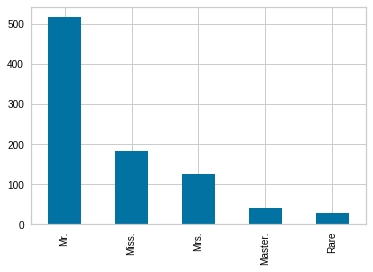

In [12]:
dataframe_transformations_test['Title'].value_counts().plot(kind='bar')

def classify_title(dataframe_in):
    dataframe_in.loc[:, ['Title']] = dataframe_in['Title'].apply(lambda X: X if X in ['Mr.', 'Miss.', 'Mrs.', 'Master.'] else 'Rare')
    return dataframe_in
    
dataframe_transformations_test = classify_title(dataframe_transformations_test)
dataframe_transformations_test['Title'].value_counts().plot(kind='bar')

We can drop out the Passenger ID and the Ticket columns.

In [13]:
dataframe_transformations_test.head()
columns_to_drop = ['PassengerId', 'Ticket']

def drop_useless_columns(columns_to_drop, dataframe_in):
    dataframe_in.drop(columns_to_drop, axis = 1, inplace = True)
    return dataframe_in

dataframe_transformations_test = drop_useless_columns(columns_to_drop, dataframe_transformations_test)

We can also dummify the sex column: convert the categorical data to zeros and ones:

In [14]:
def convert_sex_to_number(dataframe_in):
    dataframe_in['Sex'] = dataframe_in['Sex'].apply(lambda X: 0 if X == 'female' else 1)
    return dataframe_in

dataframe_transformations_test = convert_sex_to_number(dataframe_transformations_test)

In [15]:
dataframe_transformations_test.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,NaN,S,Mr.
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C85,C,Mrs.
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,NaN,S,Miss.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C123,S,Mrs.
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,NaN,S,Mr.


# 2.3. Cabin Analysis
* The same problem that we found with the Title attribute can be seen here: we have many cabins. To start our analysis here, let's get just the first letter of the cabin and consider that letter as a classification label.

In [16]:
dataframe_transformations_test.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [17]:
def get_cabin_letter(dataframe_in):
    dataframe_in['Cabin'] = dataframe_in['Cabin'].apply(lambda X: re.search('[A-Za-z]{1}', X).group(0).upper() if isinstance(X, str) else '?')
    return dataframe_in
    
dataframe_transformations_test = get_cabin_letter(dataframe_transformations_test)
dataframe_transformations_test.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,?,S,Mr.
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,C,Mrs.
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,?,S,Miss.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C,S,Mrs.
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,?,S,Mr.


During the data analysis step, we have already seen that there are also many missing data when we are looking at the Cabin column. A first approach to fill the empty vales is to assume that people from the same family are also in the same cabin. So, let's write a function to collect the family name of each passenger and check all the rows without a known cabin. Then, let's fill those fields with a cabin of another member of the family.

We can drop out the name column after that, as we have already got all the possible information from the passenger names. After this procedure, we are still going to find many missing cabins. Let's simply input "?" on those cabins since the fact that this field is unkown can be used as a information itself. If a cabin is unknown for a passenger then, maybe, that cabin was located in a more dangerous place.

In [18]:
def get_family_name(dataframe_in):
    dataframe_in['FamilyName'] = dataframe_in['Name'].apply(lambda X: re.search('[A-Z]{1}[a-z ]+', X).group(0))
    return dataframe_in

dataframe_transformations_test = get_family_name(dataframe_transformations_test)
dataframe_transformations_test.drop(['Name'], axis = 1, inplace = True)

dict_cabins_per_family = dict()
for current_family_name in dataframe_transformations_test.FamilyName.unique().tolist():
    filter_family_name = (dataframe_transformations_test['FamilyName'] == current_family_name)
    filter_known_cabin = (dataframe_transformations_test['Cabin'] != '?')
    listCabinsFromFamily = dataframe_transformations_test.loc[(filter_family_name) &\
                                                              (filter_known_cabin)].Cabin.unique().tolist()
    
    if len(listCabinsFromFamily) > 0:
        max_v, mode = 0, None
        for curr_cabin, v in Counter(listCabinsFromFamily).items():
            if v > max_v:
                max_v, mode = v, curr_cabin
        dict_cabins_per_family[current_family_name] = mode

def get_family_cabin_per_row(df_row):
    if df_row.FamilyName in dict_cabins_per_family and df_row.Cabin == '?':
        out = dict_cabins_per_family[df_row.FamilyName]
    else:
        out = df_row.Cabin
    return out

def get_family_cabin(df):
    
    df['Cabin'] = df.apply(get_family_cabin_per_row, axis = 1)
    df['Cabin'] = df['Cabin'].fillna('?')
    
    return df

dataframe_transformations_test['Cabin'] = get_family_cabin(dataframe_transformations_test)
dataframe_transformations_test.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Cabin           0
Embarked        2
Title           0
FamilyName      0
dtype: int64

We still have two more columns with missing data and our next step is to get the easiest one: the "Embarked" column...

# 2.4. Embarked Analysis
Filling this column with the most frequent occurence (the median) would not lead us to a great loss on the quality of out analysis as we have just 2 rows with that problem:

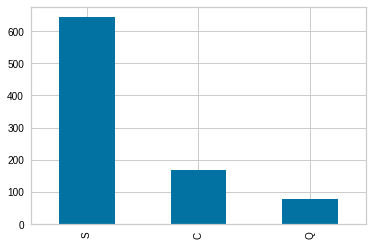

In [19]:
dataframe_transformations_test['Embarked'].value_counts().plot(kind = 'bar')

In [20]:
def embarked_fillna_median(df):
    df.loc[:, ['Embarked']] = df['Embarked'].fillna(value = df['Embarked'].value_counts().idxmax())
    return df

dataframe_transformations_test = embarked_fillna_median(dataframe_transformations_test)
dataframe_transformations_test.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Cabin           0
Embarked        0
Title           0
FamilyName      0
dtype: int64

# 2.5.A. Age Analysis - A Simple Approach
We can see in the following curves that every people with a "Master." title tends to have a small age at aroung 10 years. Since we have a low variance in that subset of samples, we can just fill the masters column with the average age of the masters.

Then we just repeat the procedure to the non masters. It would lead us to a better approach to threat the missing age data. It's a really simple approach but by doing this and using a convenient structure of classifiers it's possible to reach a good final accuracy as we are going to see later.

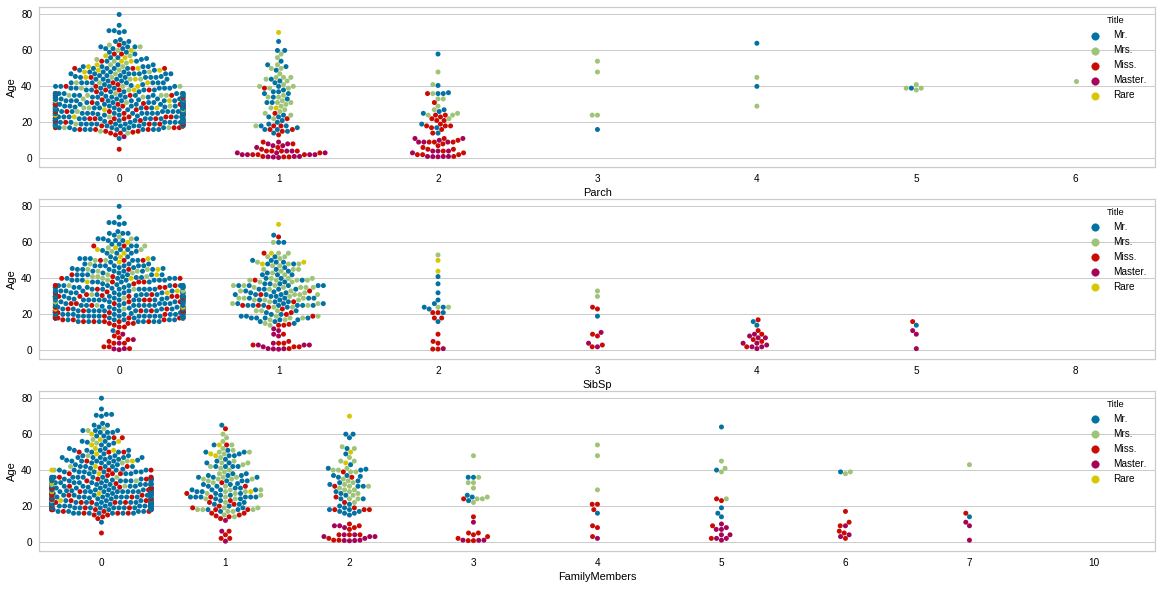

In [21]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

dataframe_transformations_test['FamilyMembers'] = dataframe_transformations_test['SibSp'] + dataframe_transformations_test['Parch']

sns.catplot(x = 'Parch', y = 'Age', hue = 'Title', data = dataframe_transformations_test, kind = "swarm", ax = ax1)
plt.close(2)
sns.catplot(x = 'SibSp', y = 'Age', hue = 'Title', data = dataframe_transformations_test, kind = "swarm", ax = ax2)
plt.close(2)
sns.catplot(x = 'FamilyMembers', y = 'Age', hue = 'Title', data = dataframe_transformations_test, kind = "swarm", ax = ax3)
plt.close(2)

In [22]:
is_master = (dataframe_transformations_test['Title'] == 'Master.')
master_age_series = dataframe_transformations_test.loc[is_master]['Age']
print(master_age_series.mean())
print(master_age_series.median())
print(master_age_series.std())

4.574166666666667
3.5
3.6198716433439615


In [23]:
def fill_age_from_masters(df, strategy_in = 'median'):
    is_master = (df['Title'] == 'Master.')
    imp = SimpleImputer(missing_values = np.nan, strategy = strategy_in)
    df.loc[is_master, 'Age'] = imp.fit_transform(df.loc[is_master][['Age']])
    return df

dataframe_transformations_test = fill_age_from_masters(dataframe_transformations_test)
dataframe_transformations_test.isnull().sum()

Survived           0
Pclass             0
Sex                0
Age              173
SibSp              0
Parch              0
Fare               0
Cabin              0
Embarked           0
Title              0
FamilyName         0
FamilyMembers      0
dtype: int64

In [24]:
dataframe_transformations_test['Age'].median()

28.0

In [25]:
def fill_age_from_non_masters(df, strategy_in = 'median'):
    is_not_master = (df['Title'] != 'Master.')
    imp = SimpleImputer(missing_values = np.nan, strategy = strategy_in)
    df.loc[is_not_master, 'Age'] = imp.fit_transform(df.loc[is_not_master][['Age']])
    return df

dataframe_transformations_test = fill_age_from_non_masters(dataframe_transformations_test)
dataframe_transformations_test.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin            0
Embarked         0
Title            0
FamilyName       0
FamilyMembers    0
dtype: int64

In [26]:
dataframe_transformations_test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilyName,FamilyMembers
0,0,3,1,22.0,1,0,7.2500,0,S,Mr.,Braund,1
1,1,1,0,38.0,1,0,71.2833,1,C,Mrs.,Cumings,1
2,1,3,0,26.0,0,0,7.9250,1,S,Miss.,Heikkinen,0
3,1,1,0,35.0,1,0,53.1000,1,S,Mrs.,Futrelle,1
4,0,3,1,35.0,0,0,8.0500,0,S,Mr.,Allen,0


In [27]:
original_training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2.5.B. Age Analysis - A Clustering Approach
Filling the people with a "Master." title seems to be suficient for them since it was possible to observe that they were all young people with an age distribution characterized by a low variance. 

But this assumption doesn't seem to hold really well when we are talking about the "Non Masters". So, my approach to solve this problem is exposed in the following sequence of steps:

1. Check the correlation of the "Age" column with all the other columns and identify which variables are more correlated with it.
2. Take these variables and use them to cluster the passenger in different groups - We will have a problem here: categorical variables should be dummified before the clustering algorithm and, after the dummifying procedure, we will obtain many sparse columns on the pre processed matrix.
3. So, to solve the sparse columns problem, we will run a Principal Component Analysis over the Dummyfied dataset, get the principal componentes obtained and run the clustering algorithm over these principal components.
4. The clustering algorithm used will be a simple K-Means. The value of K (Number of clusters) will be obtained by a Silhouette Analysis, which will be explained later.

So, we can't start this analysis at this point, we need to follow these steps after pre processing the data, and we will come back to this approach later.

# 3. Pre Processing
After the exploratory analysis we can pre process the variables. This part is composed of two steps: first we define the transformations in a modular form, then we blend them in a pipeline.

# 3.1. Defining Transformations
The "TransformerSignificantData" has the objective to realize the necessary interpretations over the basic dataset and is strongly based on the exploratory analysis that we have done in the section 2. It's composed by the following steps:

* Get the first letters of each cabin
* Get the title from each name
* Classify the title according to the convention defined in 2.
* Get the family name for each passenger and
* Use the family names to expand the labels to other people with unknown cabins

The last step will not fill all the missing cabin data but can, at least, give us a better glimpse over some passengers.

In [28]:
class TransformerSignificantData(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        out = get_cabin_letter(X)
        out = get_title(out)
        out = classify_title(out)
        out = get_family_name(out)
        out = get_family_cabin(out)
        
        return out

The transformer dummify variable will be used to handle the categorical columns. The columns listed in dim_redundant_columns will be removed to avoid the "Curse of Dimensionality" problem. It happens when you have more columns than the necessary to code the dataset.

In [29]:
class TransformerDummify(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        columns_to_dummify = ['Sex', 'Cabin', 'Embarked', 'Title']
        useless_columns = ['PassengerId', 'Name', 'Ticket', 'FamilyName']
        dim_redundant_cols = ['Sex_male', 'Cabin_?', 'Embarked_S', 'Title_Rare']
        
        out_dummies = pd.get_dummies(X[columns_to_dummify], prefix = columns_to_dummify)
        
        out = pd.concat([X, out_dummies], axis = 1)
        out = out.drop(useless_columns + columns_to_dummify + dim_redundant_cols, axis = 1)
        
        return out

The transformer missing data will fill the "Age" rows with missing data considering the procedure described in section 2: if the person is a "Master', we'll input the masters average age and the non masters average age will be placed in the othwe missing age rows. The same procedure will be used to fill the "Fare" column

In [30]:
class TransformerMissingData(BaseEstimator, TransformerMixin):
    
    def __init__(self, missing_age_masters_strategy = 'mean', missing_age_non_masters_strategy = 'mean'):
        self.missing_age_masters_strategy = missing_age_masters_strategy
        self.missing_age_non_masters_strategy = missing_age_non_masters_strategy
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):

        is_not_master = (X['Title_Master.'] == 0)
        is_master = (X['Title_Master.'] == 1)
        
        imp_non_master = SimpleImputer(missing_values = np.nan, 
                                       strategy = self.missing_age_non_masters_strategy)
        
        imp_master = SimpleImputer(missing_values = np.nan, 
                                   strategy = self.missing_age_masters_strategy)
        
        imp_fare = SimpleImputer(missing_values = np.nan,
                                 strategy = 'mean')
        
        X.loc[is_not_master, 'Age'] = imp_non_master.fit_transform(X.loc[is_not_master, ['Age']])
        X.loc[is_master, 'Age'] = imp_master.fit_transform(X.loc[is_master, ['Age']])
        X.loc[:, 'Fare'] = imp_fare.fit_transform(X.loc[:, ['Fare']])

        return X 

Finally, it's necessary to normalize the data. We can map the numbers on the interval $[0, 1]$ using the "MinMaxScaler" or center the intervals around the mean and divide them by the standard deviation using the "StandardScaler" transformation. Let's briefly show each possibility:
* $X = \frac{X - b}{a - b}$ - MinMaxScaler using a interval between 0 and 1, where $b$ is the minimum value observed and $a$ is the maximum value observed
* $X = \frac{X - \mu}{\sigma}$ - Where $\mu$ is the mean of the known values of the column and $\sigma$ referes to the standard deviation
The categorical values will be mapped between zero and one using the MinMaxScaler and the continuous variables (Age and Fare) will be mapped using a StandardScaler to avoid the high sensibility to outliers present in the MinMaxScaler.

In [31]:
class TransformerNormalize(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        out = X
        out.loc[:, ['Pclass']] = MinMaxScaler().fit_transform(out[['Pclass']])
        out.loc[:, ['Age', 'Fare']] = StandardScaler().fit_transform(out[['Age', 'Fare']])
        
        return out

# 3.2. Enhancing the Missing Age Solution
Let's get our dummy dataset and follow the sequence steps proposed on the section 2.5.B.

In [32]:
df_dummy = pd.concat([pd.read_csv('/kaggle/input/train.csv'), pd.read_csv('/kaggle/input/test.csv')], ignore_index = True)
dummy_pipeline = Pipeline([
    ('prepare', TransformerSignificantData()),
    ('dummify', TransformerDummify()),
    ('normalize', TransformerNormalize())
])
df_dummy = dummy_pipeline.transform(df_dummy)
df_dummy.head()

FileNotFoundError: [Errno 2] File b'/kaggle/input/train.csv' does not exist: b'/kaggle/input/train.csv'

In [ ]:
df_dummy = df_dummy[df_dummy['Title_Master.'] == 0]
df_dummy.head()

Which variables are most correlated to the age? We can check the correlation table to get the answer:

In [ ]:
df_dummy_corr = df_dummy.corr().apply(abs).sort_values(by = 'Age', axis = 0, ascending = False)
sns.set(rc={'figure.figsize':(12.0,10.0)})
sns.heatmap(df_dummy_corr, annot=False, cmap='YlGnBu')

In [ ]:
df_dummy_corr.loc[df_dummy_corr.index.values != 'Age', :]['Age'].plot.bar()

The next step is to get the Principal Components of this

We can confirm that if we have a master, then the absolute value of the correlation will be significant and we have already found a simple way to threat it. So, we are going to ignore the "Title_Master" column. We can, then, observe some correlation with the age for the following variables:

In [ ]:
related_to_age = ['Pclass', 'Title_Miss.', 'SibSp', 'Cabin_C', 'Title_Mr.', 'Fare', 'Parch']

We just selected all the variables with more than $15\%$ of Pearson Coefficient. Now, it's time to decompose these columns in Principal Components (PCA - Principal Component Analysis).

In [ ]:
df_pca = df_dummy.copy().loc[:, related_to_age]
df_pca.isnull().sum()

In [ ]:
df_pca = df_pca.fillna(value = df_pca['Fare'].mean())
df_pca.isnull().sum()

In [ ]:
pca_age = PCA().fit(df_pca)
df_explained_var = pd.DataFrame({
    'Index': range(0, len(pca_age.explained_variance_ratio_)),
    'Ratio': pca_age.explained_variance_ratio_,
    'Cumulative': np.cumsum(pca_age.explained_variance_ratio_)
})
ggplot(data = df_explained_var, mapping = aes(x = 'Index')) +\
    geom_bar(mapping = aes(y = 'Ratio'), stat = 'identity') +\
    geom_line(mapping = aes(y = 'Cumulative'), stat = 'identity')

In [ ]:
np.cumsum(pca_age.explained_variance_ratio_)

Clustering over the 3 most important principal components will give us $80%$ of explained variance. Let's plot these variables over a $R^3$ space and check the pattern of the points:

In [ ]:
np_pca_significant = pca_age.transform(df_pca.copy())[:, :3]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection = '3d')

xs = np_pca_significant[:, 1]
ys = np_pca_significant[:, 2]
zs = np_pca_significant[:, 0]
ax.scatter(xs, ys, zs, s = 50, alpha = 0.6, edgecolors = 'w')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X0')

plt.xlim(-3, 2)

plt.show()

It seems that we can aggregate the points in $4$ clusters, divided by planes. Let's try to do so by trying to find an optimal clustering algorithm:
* We can compare a K-Means algorithm among many different values of K. The optimal value can be calculated by getting the higher average silhouette score.
* Then, we can try to run a DBSCAN algorithm (Density-Based Spatial Clustering of Applications with Noise)

We can notice that the best K-Means model is not as good as the DBSCAN one. The hyperparameters of the DBSCAN algorithm were found directly by a inspection over the 3D plot of points.

In [ ]:
kmeans2 = KMeans(n_clusters = 2, random_state = 42, n_init = 500).fit_predict(np_pca_significant)
kmeans3 = KMeans(n_clusters = 3, random_state = 42, n_init = 500).fit_predict(np_pca_significant)
kmeans4 = KMeans(n_clusters = 4, random_state = 42, n_init = 500).fit_predict(np_pca_significant)
kmeans5 = KMeans(n_clusters = 5, random_state = 42, n_init = 500).fit_predict(np_pca_significant)
kmeans6 = KMeans(n_clusters = 6, random_state = 42, n_init = 500).fit_predict(np_pca_significant)

In [ ]:
dbscan_model = DBSCAN(eps = 0.7, min_samples = 20).fit(np_pca_significant)
dbscan_predict = dbscan_model.fit_predict(np_pca_significant)

In [ ]:
silhouette_avg2 = silhouette_score(np_pca_significant, kmeans2)
silhouette_avg3 = silhouette_score(np_pca_significant, kmeans3)
silhouette_avg4 = silhouette_score(np_pca_significant, kmeans4)
silhouette_avg5 = silhouette_score(np_pca_significant, kmeans5)
silhouette_avg6 = silhouette_score(np_pca_significant, kmeans6)

df_avg_silh = pd.DataFrame({
    'Avg. Silh. Score': [silhouette_avg2, silhouette_avg3, silhouette_avg4, silhouette_avg5, silhouette_avg6],
    'K': [2, 3, 4, 5, 6]
})

ggplot(df_avg_silh, aes(x = 'K', y = 'Avg. Silh. Score')) + geom_line(stat = 'identity')

The average silhouette score is maximum when $K = 3$. So, let's color the data points and check what happens:

In [ ]:
np_pca_significant = pca_age.transform(df_pca.copy())[:, :3]

fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(121, projection = '3d')

xs = np_pca_significant[:, 1]
ys = np_pca_significant[:, 2]
zs = np_pca_significant[:, 0]
dict_color = {0: 'b', 1: 'r', 2: 'k', 3: 'g', 4: 'c', 5: 'y', 6: 'm'}
ax.scatter(xs, ys, zs, s = 50, alpha = 0.6, edgecolors = 'w', 
           c = [dict_color[i % 7] for i in dbscan_predict])

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X0')
ax.title.set_text('DBSCAN Clusters')

plt.xlim(-3, 2)

ax = fig.add_subplot(122, projection = '3d')

xs = np_pca_significant[:, 1]
ys = np_pca_significant[:, 2]
zs = np_pca_significant[:, 0]
dict_color = {0: 'b', 1: 'r', 2: 'k', 3: 'g', 4: 'c', 5: 'y', 6: 'm'}
ax.scatter(xs, ys, zs, s = 50, alpha = 0.6, edgecolors = 'w', 
           c = [dict_color[i % 7] for i in kmeans3])

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X0')
ax.title.set_text('Best KNN (K=3) Clusters')

plt.xlim(-3, 2)

plt.show()

So, we are going to assign to each row with missing ages the mean value of the age for its respective cluster using the DBSCAN algorithm. Would it be better than just assign the mean value to all non masters missing age rows?

We can't assure that. That's why we'll slightly change the missing age transformation, adding one more option to the hyperparameter that determines the missing age filling procedure:

In [ ]:
class TransformerMissingData(BaseEstimator, TransformerMixin):
    
    def __init__(self, missing_age_masters_strategy = 'mean', missing_age_non_masters_strategy = 'cluster'):
        self.missing_age_masters_strategy = missing_age_masters_strategy
        self.missing_age_non_masters_strategy = missing_age_non_masters_strategy
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):

        is_not_master = (X['Title_Master.'] == 0)
        is_master = (X['Title_Master.'] == 1)
        
        imp_non_master = SimpleImputer(missing_values = np.nan, 
                                       strategy = self.missing_age_non_masters_strategy)
        
        imp_master = SimpleImputer(missing_values = np.nan, 
                                   strategy = self.missing_age_masters_strategy)
        
        imp_fare = SimpleImputer(missing_values = np.nan,
                                 strategy = 'mean')
        
        X.loc[is_master, 'Age'] = imp_master.fit_transform(X.loc[is_master, ['Age']])
        X.loc[:, 'Fare'] = imp_fare.fit_transform(X.loc[:, ['Fare']])
        
        if self.missing_age_non_masters_strategy in ['mean', 'median']:
            X.loc[is_not_master, 'Age'] = imp_non_master.fit_transform(X.loc[is_not_master, ['Age']])
            
        elif self.missing_age_non_masters_strategy == 'cluster':
            
            X_without_age = X.drop(['Age', 'Survived'], axis = 1)
            print(X_without_age.isnull().sum())
            pca_fit_vec = PCA(n_components = 3).fit_transform(X_without_age)
            
            X['ClusterLabel'] = DBSCAN(eps = 0.7, min_samples = 20).fit_predict(pca_fit_vec)
            dict_means_per_cluster = dict()
            for cluster_label in X['ClusterLabel'].tolist():
                dict_means_per_cluster[cluster_label] = X.loc[X['ClusterLabel'] == cluster_label, :]['Age'].mean()
            
            age_list = X['Age'].tolist()
            cluster_list = X['ClusterLabel'].tolist()
            for i, curr_age in enumerate(age_list):
                if np.isnan(curr_age):
                    age_list[i] = dict_means_per_cluster[cluster_label]
            X['Age'] = age_list
                
        return X

# 3.3. Defining the Pre Processing Pipeline

Then, we can finally chain all of these transformations in a pipeline, that will be applied over our dataset before training, testing and validating our models. It's important to see that, since we are using a standard scaler, the pipeline must be used over the whole dataset (training + testing) at once. If we ignore this observation, we will have the same value of a non categorical column mapped to two different values over the training and testing sets.

In [ ]:
feature_engineering_pipeline = Pipeline([
    ('prepare', TransformerSignificantData()),
    ('dummify', TransformerDummify()),
    ('normalize', TransformerNormalize()),
    ('missing', TransformerMissingData())
])

df_all_original = pd.concat([pd.read_csv('/kaggle/input/train.csv'), 
                             pd.read_csv('/kaggle/input/test.csv')], ignore_index = True)
df_all_original.head()

In [ ]:
df_all_processed = feature_engineering_pipeline.transform(df_all_original.copy())
df_all_processed.head()

In [ ]:
df_all_processed.isnull().sum()

Finally, we can split our variables in training set, training labels and testing set. The results obtained over the testing set will be submited. Here comes a tricky part: we should never use the validation set to test our results. We will actually compare the validation results with a test set that we will split out of the samples before starting the cross validation step: testing the results in a training set where the training and tunning were not realized can let us get a better information about the generalization power of the estimators.

So:
* The parameters of the models are determined over the training set
* The hyper parameters of the models are determined over the validation set and
* The best model will be get comparing each one of the obtained models over the testing set

In [ ]:
df_ans = df_all_processed[df_all_processed['Survived'].isnull()]
df_ans = df_ans.loc[:, df_ans.columns != 'Survived']

df_cv_and_test = df_all_processed[df_all_processed['Survived'].notnull()]

df_cv_and_test_X = df_cv_and_test.drop(['Survived', 'ClusterLabel'], axis = 1)
df_cv_and_test_Y = df_cv_and_test['Survived']

df_cv_X, df_test_X, df_cv_Y, df_test_Y = train_test_split(df_cv_and_test_X,
                                                          df_cv_and_test_Y,
                                                          test_size = 0.1,
                                                          random_state = 42)

# 4. Applying Different Machine Learning Models

$3$ simple models are goind to be used over our preprocessed dataset:
* A Random Forest Classifier
* A Support Vector Machine
* And a Logistic Regression
After that, we are going to see how to combine these models into a better classifier by using different types of "Ensemble Learning" techniques.

# 4.1. Training and Testing the Models
# 4.1.A. Training and Testing Single Models
The models will be trained and tested all over the testing set using a K-Fold Cross Validation. The optimal hyper parameters are sequentially inspected. 
The Grid Search technique over the Cross Validation folds will be used to find the optimal values for these parameters. Tuning the hyper parameters if important to avoid overfitting: they are responsible for the correct regularization of our models.

In [ ]:
hyper_rf = dict(
    n_estimators = [85, 86, 87, 88, 89], # OPT = 88
    max_depth = [3, 4, 5, 6, 7, 8, 9, 10],
    random_state = [42]
)

hyper_svm = dict(
    C = [6.0, 7.0, 8.0], # 7 = OPT
    kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
    gamma = ['auto', 'scale'],
    probability = [True],
    random_state = [42]
)

hyper_logit = dict(
    C = [0.1, 1.0, 10.0], # 1 = OPT
    solver = ['lbfgs'],
    random_state = [42]
)

hyper_adaboost = dict(
    n_estimators = [54, 55, 56],# 55 = OPT
    learning_rate = [0.35, 0.4, 0.45], # 0.4 = OPT
    random_state = [42]
)

hyper_xgboost = {
    'eta': [0, 0.00001], # 0 = OPT
    'gamma': [0.001, 0.05, 0.1], # 0.05 =OPT
    'max_depth': [3, 4, 5], # 4 = OPT
    'probability': [True],
    'random_state': [42]
}

In [ ]:
n_cv = 10

gscv_rf = GridSearchCV(RandomForestClassifier(), hyper_rf, scoring = 'accuracy', cv = n_cv)
gscv_svm = GridSearchCV(SVC(), hyper_svm, scoring = 'accuracy', cv = n_cv)
gscv_logit = GridSearchCV(LogisticRegression(), hyper_logit, scoring = 'accuracy', cv = n_cv)
gscv_adab = GridSearchCV(AdaBoostClassifier(), hyper_adaboost, scoring = 'accuracy', cv = n_cv)
gscv_xbt = GridSearchCV(XGBClassifier(), hyper_xgboost, scoring = 'accuracy', cv = n_cv)

Avoid the temptation of testing the score over the validation set - you can get too optimistic results! Then, let's start by splitting our dataset in testing and training / validation dataset

In [ ]:
print('1. Fitting Random Forest')
gscv_rf.fit(df_cv_X.copy(), df_cv_Y.copy())
print('2. Fitting SVM')
gscv_svm.fit(df_cv_X.copy(), df_cv_Y.copy())
print('3. Fitting Logit')
gscv_logit.fit(df_cv_X.copy(), df_cv_Y.copy())
print('4. Fitting AdaBoost')
gscv_adab.fit(df_cv_X.copy(), df_cv_Y.copy())
print('5. Fitting XBoostTree')
gscv_xbt.fit(df_cv_X.copy(), df_cv_Y.copy())

The boxplots represent the training scores and the bars represent the respective scores over the training set. The higher the bar score is, the better is the generalization power of our model.

In [ ]:
def get_CV_score(classifier_name, n_cv):
    ans = [0] * n_cv
    for i in range(0, n_cv):
        command_str = classifier_name + '.cv_results_[\'split' + str(i) + '_test_score\']'
        ans[i] = eval(command_str)[0]
    return ans

train_score_list_rf = get_CV_score('gscv_rf', n_cv)
train_score_list_svm = get_CV_score('gscv_svm', n_cv)
train_score_list_logit = get_CV_score('gscv_logit', n_cv)
train_score_list_adab = get_CV_score('gscv_adab', n_cv)
train_score_list_xbt = get_CV_score('gscv_xbt', n_cv)

df_train_score = pd.DataFrame(dict(
    estimator = ['1. rf'] * n_cv + ['2. svm'] * n_cv + ['3. logit'] * n_cv + ['4. adaboost'] * n_cv + ['5. xboosttree'] * n_cv,
    score = train_score_list_rf + train_score_list_svm + train_score_list_logit + train_score_list_adab + train_score_list_xbt
))

df_test_score = pd.DataFrame(dict(
    estimator = ['1. rf'] + ['2. svm'] + ['3. logit'] + ['4. adaboost'] + ['5. xboosttree'],
    score = [accuracy_score(gscv_rf.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_svm.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_logit.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_adab.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_xbt.best_estimator_.predict(df_test_X), df_test_Y)]
))

ggplot(aes(x = 'estimator', color = 'estimator', y = 'score')) +\
    geom_boxplot(data = df_train_score) +\
    geom_jitter(data = df_train_score) + coord_cartesian(ylim = [0.7, 1]) +\
    geom_bar(data = df_test_score, stat = 'identity', alpha = 0.2, position = "dodge")

In [ ]:
def print_opt_hyper(dict_hyper, model):
    for k in dict_hyper.keys():
        print(k + ': ' + str(model.best_estimator_.get_params()[k]) + ' -- ' + str(dict_hyper[k]))

print('Optimal Hyperparameters:')
print('---')
print('1. Random Forest')
print_opt_hyper(hyper_rf, gscv_rf)
print('---')
print('2. SVM')
print_opt_hyper(hyper_svm, gscv_svm)
print('---')
print('3. Logistic Regression')
print_opt_hyper(hyper_logit, gscv_logit)
print('---')
print('4. Ada Boost')
print_opt_hyper(hyper_adaboost, gscv_adab)
print('---')
print('5. XGBTree')
print_opt_hyper(hyper_xgboost, gscv_xbt)
print('---')

# 4.1.B. Evaluate Learning Curves of the Single Models
It's important to evaluate the learning curve of each model to check if they are underfitted or overfitted by comparing the training score with the validation score.

In [ ]:
def plot_learning_curve(train_scores, valid_scores, train_sizes):
    
    size_x_valid, size_y_valid = valid_scores.shape
    size_x_train, size_y_train = train_scores.shape
    
    Y_df_valid = []
    X_df_valid = []
    
    Y_df_train = []
    X_df_train = []
    
    for i in range(0, len(train_sizes)):
        for j in range(0, size_y_valid):
            Y_df_valid.append(valid_scores[i][j])
            X_df_valid.append(train_sizes[i])
            
    for i in range(0, len(train_sizes)):
        for j in range(0, size_y_train):
            Y_df_train.append(train_scores[i][j])
            X_df_train.append(train_sizes[i])
            
    df_valid = pd.DataFrame({'X': X_df_valid, 'Y': Y_df_valid})
    df_train = pd.DataFrame({'X': X_df_train, 'Y': Y_df_train})
    
    return df_valid, df_train

In [ ]:
train_sizes_rf, train_scores_rf, valid_scores_rf = learning_curve(gscv_rf.best_estimator_, df_cv_X.copy(), df_cv_Y.copy(), train_sizes = range(50, 700, 50), cv = 10)
df_valid, df_train = plot_learning_curve(train_scores_rf, valid_scores_rf, range(50, 700, 50))
ggplot(mapping = aes(x = 'X', y = 'Y')) + geom_point(data = df_valid, color = 'blue', size = 3, alpha = 0.1) + stat_smooth(data = df_valid, color = 'blue') +\
                                          geom_point(data = df_train, color = 'red', size = 3, alpha = 0.1) + stat_smooth(data = df_train, color = 'red') +\
                                          ggtitle('Learning Curve - Random Forest')

In [ ]:
train_sizes_svm, train_scores_svm, valid_scores_svm = learning_curve(gscv_svm.best_estimator_, df_cv_X.copy(), df_cv_Y.copy(), train_sizes = range(50, 700, 50), cv = 10)
df_valid, df_train = plot_learning_curve(train_scores_svm, valid_scores_svm, range(50, 700, 50))
ggplot(mapping = aes(x = 'X', y = 'Y')) + geom_point(data = df_valid, color = 'blue', size = 3, alpha = 0.1) + stat_smooth(data = df_valid, color = 'blue') +\
                                          geom_point(data = df_train, color = 'red', size = 3, alpha = 0.1) + stat_smooth(data = df_train, color = 'red') +\
                                          ggtitle('Learning Curve - SVM')

In [ ]:
train_sizes_logit, train_scores_logit, valid_scores_logit = learning_curve(gscv_logit.best_estimator_, df_cv_X.copy(), df_cv_Y.copy(), train_sizes = range(50, 700, 50), cv = 10)
df_valid, df_train = plot_learning_curve(train_scores_logit, valid_scores_logit, range(50, 700, 50))
ggplot(mapping = aes(x = 'X', y = 'Y')) + geom_point(data = df_valid, color = 'blue', size = 3, alpha = 0.1) + stat_smooth(data = df_valid, color = 'blue') +\
                                          geom_point(data = df_train, color = 'red', size = 3, alpha = 0.1) + stat_smooth(data = df_train, color = 'red') +\
                                          ggtitle('Learning Curve - Logistic Regression')

In [ ]:
train_sizes_adab, train_scores_adab, valid_scores_adab = learning_curve(gscv_adab.best_estimator_, df_cv_X.copy(), df_cv_Y.copy(), train_sizes = range(50, 700, 50), cv = 10)
df_valid, df_train = plot_learning_curve(train_scores_adab, valid_scores_adab, range(50, 700, 50))
ggplot(mapping = aes(x = 'X', y = 'Y')) + geom_point(data = df_valid, color = 'blue', size = 3, alpha = 0.1) + stat_smooth(data = df_valid, color = 'blue') +\
                                          geom_point(data = df_train, color = 'red', size = 3, alpha = 0.1) + stat_smooth(data = df_train, color = 'red') +\
                                          ggtitle('Learning Curve - Adaboost')

In [ ]:
train_sizes_xbt, train_scores_xbt, valid_scores_xbt = learning_curve(gscv_xbt.best_estimator_, df_cv_X.copy(), df_cv_Y.copy(), train_sizes = range(50, 700, 50), cv = 10)
df_valid, df_train = plot_learning_curve(train_scores_xbt, valid_scores_xbt, range(50, 700, 50))
ggplot(mapping = aes(x = 'X', y = 'Y')) + geom_point(data = df_valid, color = 'blue', size = 3, alpha = 0.1) + stat_smooth(data = df_valid, color = 'blue') +\
                                          geom_point(data = df_train, color = 'red', size = 3, alpha = 0.1) + stat_smooth(data = df_train, color = 'red') +\
                                          ggtitle('Learning Curve - Extreme Boosting Tree')

So, we have compared each one of the optimal single models. It's interesting to ask ourselves: would it be better to blent these models into a single one and check if we can get even better results? The answer is yes and we will see different approaches in the next section.

Looking at the learning curves we can notice that we don't have overfitting the models. Maybe the Random Forest and the XBoost Tree is underfitted, even after tunning their hyper parameters. Since the validation curve ends with a horizontal slope for both cases, the problem doesn't seem to be solvable by just changing the (already tunned) regularization constants.

So, the curves suggest that we need to extract more significant features from the dataset or increase the training set size to reach an optimal testing score. The bigger sample used during the submission step as well as the use of ensembling models can be used as a solution to this problem.

# 4.1.C. Training and Testing Ensemble Models
The models can be combined in different ways:
* In a "Voting Classifier", each model has a vote and the winning guess will represent the output of the composed estimator. This classifier can be divided in two types:
    * The "Hard Voting Classifier" is composed by models that have, all of them, a vote with weight one - So, in this case, all models have the same contribution over each output
    * In the "Soft Voting Classifier", each model contribute with the estimated final probability, which can be any value in the interval $[0, 1]$. So, the vote of models that are more "confident" about the answer will have a bigger priority for each one of the inputs
* Finally, we can construct a "Meta Classifier", in a process known as "Stacking", where the outputs of each model serve as input to another model and its output will represent the final answer. Notice that it's also possible to stack models in multiple layers.

The process of combining multiple models into an ensemble classifier is called "Stacking". The quality of this type of model tends to be better when the models are independent. In this case, the law of large numbers hold and the final accuracy will have a tendence to be bigger.

In [ ]:
estimator_list = [('rf', gscv_rf.best_estimator_), 
                  ('svm', gscv_svm.best_estimator_), 
                  ('logit', gscv_logit.best_estimator_),
                  ('adab', gscv_adab.best_estimator_),
                  ('xbt', gscv_xbt.best_estimator_)]

hard_vote_estimator = VotingClassifier(estimator_list)
soft_vote_estimator = VotingClassifier(estimator_list)
meta_logit_estimator = StackingClassifier(classifiers = [X[1] for X in estimator_list], 
                                          meta_classifier = LogisticRegression())

In [ ]:
%%capture

hard_cv = GridSearchCV(hard_vote_estimator, param_grid = {'voting': ['hard']}, 
                       scoring = 'accuracy', cv = n_cv).fit(df_cv_X.copy(), df_cv_Y.copy())

soft_cv = GridSearchCV(soft_vote_estimator, param_grid = {'voting': ['soft']},
                       scoring = 'accuracy', cv = n_cv).fit(df_cv_X.copy(), df_cv_Y.copy())

stack_cv = GridSearchCV(meta_logit_estimator, param_grid = {'meta_classifier__C': [0.1, 1, 10, 100, 500]},
                        scoring = 'accuracy', cv = n_cv).fit(df_cv_X.copy(), df_cv_Y.copy())

In [ ]:
print('Hard Voting Score: ' + str(hard_cv.best_score_))
print('Soft Voting Score: ' + str(soft_cv.best_score_))
print('Stacking Score: ' + str(stack_cv.best_score_))

In [ ]:
train_score_list_hv = get_CV_score('hard_cv', n_cv)
train_score_list_sv = get_CV_score('soft_cv', n_cv)
train_score_list_st = get_CV_score('stack_cv', n_cv)

df_train_score = pd.DataFrame(dict(
    estimator = ['1. rf'] * len(train_score_list_rf) + 
                ['2. svm'] * len(train_score_list_svm) + 
                ['3. logit'] * len(train_score_list_logit) +
                ['4. adaboost'] * len(train_score_list_adab) +
                ['5. xbtree'] * len(train_score_list_xbt) +
                ['6. hard voter'] * len(train_score_list_hv) + 
                ['7. soft voter'] * len(train_score_list_sv) +
                ['8. stacking'] * len(train_score_list_st)
    , score = train_score_list_rf + train_score_list_svm + train_score_list_logit + train_score_list_adab +\
                            train_score_list_xbt + train_score_list_hv + train_score_list_sv + train_score_list_st
))

df_test_score = pd.DataFrame(dict(
    estimator = ['1. rf'] + ['2. svm'] + ['3. logit'] + ['4. adaboost'] + ['5. xbtree'] + ['6. hard voter'] + ['7. soft voter'] + ['8. stacking'],
    score = [accuracy_score(gscv_rf.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_svm.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_logit.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_adab.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(gscv_xbt.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(hard_cv.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(soft_cv.best_estimator_.predict(df_test_X), df_test_Y),
             accuracy_score(stack_cv.best_estimator_.predict(df_test_X), df_test_Y),
            ]
))

ggplot(aes(x = 'estimator', y = 'score', color = 'estimator')) + geom_boxplot(data = df_train_score) +\
       geom_jitter(data = df_train_score) + theme(axis_text_x = element_text(angle = 70, 
                                                  hjust = 1, vjust = 0.5)) + coord_cartesian(ylim = [0.7, 1]) +\
       geom_bar(data = df_test_score, stat = 'identity', alpha = 0.2, position = "dodge")

# 4.1.D. Bonus - Plotting Feature Importances
Sometimes, in data science projects, we can get more results after the first implementation. That's why we can't say that there exists a fixed framework: it's common to work in cycles, in a procedure called CRISP-DM (which stands for "Cross-Industry Standard Process for Data Mining". 

Then, if we get any insight from the following graphic that will be shown, we can just go back to the feature engineering part and readapt out analysis. With an optimal model of Random Forests, we can plot the feature importances as we can see in the next figure.

In [ ]:
importance_list = gscv_rf.best_estimator_.feature_importances_.tolist()
df_feature_importances = pd.DataFrame({
    'Feature': df_cv_X.columns,
    'Importance': importance_list
})
df_feature_importances.sort_values(by = 'Importance', axis = 0, ascending = False, inplace = True)
df_feature = df_deature.set_index(1:)
df_feature_importances.head()

In [ ]:
ggplot(data = df_feature_importances, mapping = aes(x = 'Feature', y = 'Importance')) + geom_bar(stat = 'identity') + theme(axis_text_x = element_text(angle = 70, hjust = 1, vjust = 10))

And these informations can serve as informations to be used in an enhanced model, considering that the weight of the most important features should have a bigger weight than the weight of the other columns.

# 5. Final Submission
We can notice that the optimal solution is represented by the soft voter model. Which performs slightly better than the support vector machine (SVM). The cell below produces a link with the final result using the soft voter obtained. By using this file we can reach an accuracy of $79.9 \%$ approximately. And reach the top $15 \%$. You can use this part of the code as an example of how to get the results easily and then submit them.

In [ ]:
%%capture

submission_estimator = soft_cv.best_estimator_.fit(df_cv_and_test_X, df_cv_and_test_Y)
survival_ans_col = pd.DataFrame({'Survived': submission_estimator.predict(df_ans)})

df_submission = pd.read_csv('/kaggle/input/test.csv')
df_submission['Survived'] = [int(X) for X in survival_ans_col['Survived'].to_list()]
df_submission = df_submission.loc[:, ['PassengerId', 'Survived']]
df_submission.to_csv('submission.csv')

os.chdir('/kaggle/working')
df_submission.to_csv('submission.csv', index = False)
FileLink('submission.csv')